#### Axel & Tristan

In [2]:
# Packages
using Flux
using Zygote
using MLDatasets
using LinearAlgebra
using Plots
using LaTeXStrings

In [15]:

# h = 3  # Final number of hidden layers
# nodes = [100, 200, 500, 1000]  # Number of nodes in each hidden layer

# # Initialize arrays to hold models
# models_S = [] # sigmoid activation function
# models_R = [] # ReLu activation function

# for i in 1:h
#     layers_S = []
#     layers_R = []

#     # Input to first hidden layer
#     push!(layers_S, Dense(1 => n[i], σ))
#     push!(layers_R, Dense(1 => n[i], relu))

#     # Additional hidden layers
#     for j in 2:i
#         push!(layers_S, Dense(n[j] => n[j], σ))
#         push!(layers_R, Dense(n[j] => n[j], relu))
#     end

#     # Output layer
#     push!(layers_S, Dense(n[i] => 1))
#     push!(layers_R, Dense(n[i] => 1))

#     # Construct the models
#     model_i_S = Chain(layers_S...)|> f64 # Here we use Float64 instead of the typical Float32 
#     model_i_R = Chain(layers_R...)|> f64 # It's not possible to get more precison with Flux models

#     # Store the models
#     push!(models_S, model_i_S)
#     push!(models_R, model_i_R)
# end

# display(models_S)
# display(models_R)
# typeof(models_S[1])


# model1  = models_S[1] # 1->100->100->1 (Sigmoid)





Chain(
  Dense(1 => 100, σ),                   # 200 parameters
  Dense(100 => 1),                      # 101 parameters
)                   # Total: 4 arrays, 301 parameters, 2.602 KiB.

In [8]:
### Training

tMax=pi/2
Nt=Int(50)
tVec=collect(((range(start=0.0,stop=tMax,length=Nt)).^2)')
x1Vec= cos.(tVec).^2

loss(yM, y) = Flux.Losses.mse(yM,y)

# opt_state = Flux.setup(Adam(0.00003), model1)
opt_state = Flux.setup(Descent(0.0005), model1)
data1 = [(tVec, x1Vec)]

println("loss before=",loss(model1(tVec),x1Vec))

for epoch in 1:50
    Flux.train!(model1, data1, opt_state) do m, x, y
        loss(m(x), y)
    end
end
println("loss after=",loss(model1(tVec),x1Vec))



loss before=0.16509197614787993


loss after=0.1633913594623781


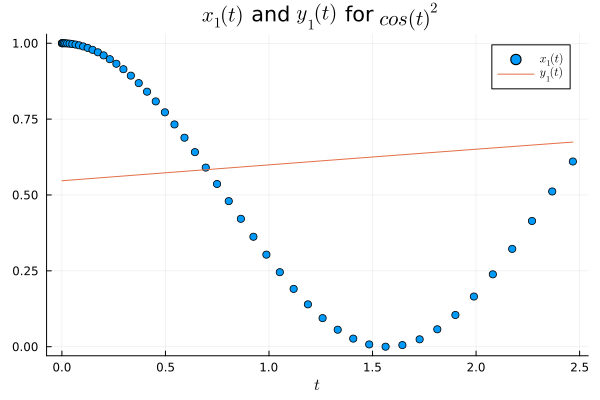

In [9]:
scatter(tVec',x1Vec',label=L"$x_1(t)$")
plot!(tVec',model1(tVec)',label=L"$y_1(t)$")
plot!(xlabel=L"$t$",title=L" $x_1(t)$ and $y_1(t)$ for $cos(t)^2$")
# display(tVec)
# display(model1)

In [4]:
input_dim = 3
Nh = 100
output_dim = 3
model1 = Chain(Dense(input_dim=>Nh, σ), Dense(Nh=>output_dim))|>f64


Chain(
  Dense(1 => 100, σ),                   # 200 parameters
  Dense(100 => 1),                      # 101 parameters
)                   # Total: 4 arrays, 301 parameters, 2.602 KiB.

In [10]:
function kernel(model, x, Nh)
    """
    This function computes the "Kernel" of a given neural network
    """
    n = length(x)
    K = zeros(Float64,n, n)  # Initialize empty Kernel
   
    
    gs = xi-> Flux.gradient(() -> model([xi])[1],Flux.params(model)) # anonymous function
    all_grads = []
    
    # Collect numerical values
    for i in 1:n
        current_grad = []
        for j in 1:length(Flux.params(model))
            push!(current_grad, gs(x[i])[Flux.params(model)[j]]/sqrt(Nh))
        end
        current_grad = collect(Iterators.flatten(current_grad)) # flatten
        push!(all_grads, current_grad)
    end

    # Evaluate each K[i,j]
    for i = 1:n
        for j = 1:n
            K[i,j] = all_grads[i]'*all_grads[j] # ' means transposed
        end
    end

    return K
end




K = kernel(model1, tVec, Nh)
λ = eigen(K).values

small_λ = []
for i in range(1, length=length(λ))
    if  λ[i] < 1.0*10^(-15)
        push!(small_λ, λ[i])
    end
end

display(small_λ)

 

45-element Vector{Any}:
 -2.7755575615628914e-16
 -2.220446049250313e-16
 -2.220446049250313e-16
 -1.9892124210524745e-16
 -1.6653345369377348e-16
 -1.6210497754712059e-16
 -1.303596162765352e-16
 -1.1865354363422152e-16
 -1.1102230246251565e-16
 -7.468401328480863e-17
  ⋮
  1.6276085118291137e-16
  1.6653345369377348e-16
  2.220446049250313e-16
  2.220446049250313e-16
  2.7755575615628914e-16
  4.440892098500626e-16
  4.996003610813204e-16
  7.216449660063518e-16
  9.165680134760385e-16

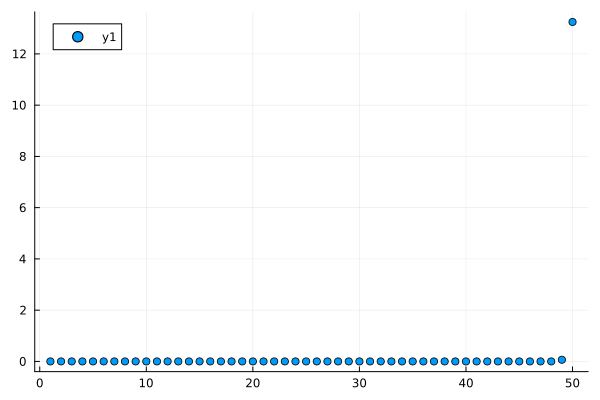

In [11]:
scatter(1:length(λ),λ)

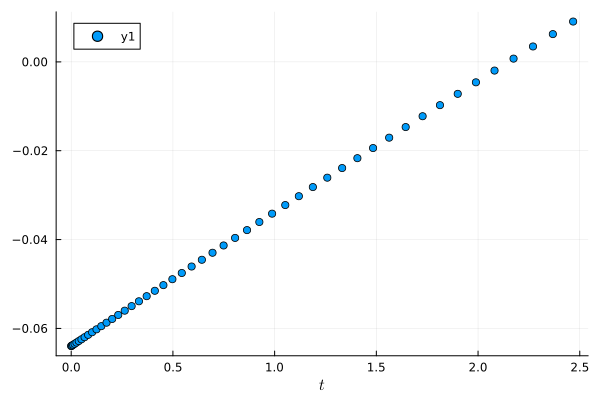

In [13]:
function df(K,model,x,y)
    fθ = model1(x)
    
    Δ = K*(fθ-y)'

    return Δ
end




Δ = df(K,model1,tVec,x1Vec)

scatter(tVec',Δ)
plot!(xlabel=L"$t$")


In [14]:
function dθ_dt(K,x,y)
    θ_list = []
    for i in 1:length(x)
            
        push!(θ_list, K[i,:]*(x[i]-x1Vec[i]))
        
    end
    dθ = -sum(θ_list)
   return dθ
end


x = model1(tVec)

Δθ = dθ_dt(K,x,x1Vec)

50-element Vector{Float64}:
  0.0639674349852965
  0.06393631167787883
  0.06384294173105128
  0.06368732511647379
  0.06346946193821942
  0.06318935265972901
  0.06284699842154164
  0.06244240144978271
  0.06197556555537559
  0.0614464967239096
  ⋮
  0.012232126494348683
  0.009739017890417024
  0.0071948435251893116
  0.004600652830604356
  0.0019575603253334413
 -0.0007332530433211276
 -0.0034705387396544093
 -0.006252979679364834
 -0.009079189486325804

In [16]:

# t is a 3-vector representing a 3-dimensional datapoint in space
# we create 3 t vectors
t1 = [1;-1;2]
t2 = [2;1;-1]
t3 = [1;1;1] 

t1 = Float64.(t1)
t2 = Float64.(t2)
t3 = Float64.(t3)
# the dimension of the kernel-matrix for 1-dimensional datapoints is nxn (where n is number of datapoints)
# the dimension of the kernel-matrix for m-dimensional datapoints is n(mxm)
# to train them all together we would create a T-matrix = [t1 t2 t3]

T = hcat(t1,t2,t3)    # matrix containing all m-dimensionl-datapoints
m = size(T)[1] # number of dimensions 
n = size(T)[2] # number of datapoints
nodes = 10 # number of nodes in hidden layers/layer

# we create a simple model to that works with the 3-dimensional datapoints 
modelM = Chain(
    Dense(m=>nodes,sigmoid),
    Dense(nodes=>m)
)|>f64


# we collect all parameters
θ_NoFlat = Flux.params(modelM)
# # Initialize an empty array to store the flattened parameters
# θ = []

# Iterate through each parameter in θ_NoFlat
# for param in θ_NoFlat
#     # Flatten the parameter and append it to θ_flat
#     append!(θ, param[:])
# end



# gs = t_i -> Flux.gradient(() -> modelM(t_i),θ_NoFlat)

# # Calculate gradients for t1
# grads = gs(t1)



Params([[0.21713589131832123 0.40326470136642456 0.632538378238678; -0.47722327709198 0.12899231910705566 -0.19242997467517853; … ; 0.6347227692604065 -0.09321050345897675 -0.13615883886814117; 0.33548760414123535 0.0032417383044958115 -0.6145402193069458], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.10905588418245316 -0.2379596084356308 … -0.027322424575686455 0.44262629747390747; -0.3174400329589844 0.15840978920459747 … 0.5803108215332031 -0.6106710433959961; 0.26723939180374146 0.4661356806755066 … -0.03441322222352028 0.16535083949565887], [0.0, 0.0, 0.0]])

In [ ]:


# function Mkernel(model, X, m, n)
#     """
#     This function computes the "Kernel" of a given neural network
#     """
    
#     K = zeros(Float64,n*m,n*m)  # Initialize empty Kernel
   

#     gs = xi-> Flux.gradient(() -> model([xi])[1],Flux.params(model)) # anonymous function
#     all_grads = []
    
#     # Collect numerical values
#     for i in 1:n
#         current_grad = []
#         for j in 1:length(Flux.params(model))
#             push!(current_grad, gs(x[i])[Flux.params(model)[j]])
#         end
#         current_grad = collect(Iterators.flatten(current_grad)) # flatten
#         push!(all_grads, current_grad)
#     end

#     # Evaluate each K[i,j]
#     for i = 1:n
#         for j = 1:n
#             K[i,j] = all_grads[i]'*all_grads[j] # ' means transposed
#         end
#     end

#     return K
# end

# K = Mkernel(modelM, T, m, n)


In [30]:
model = Chain(Dense(2=>2),Dense(2=>2))

println(size(Flux.params(model)[2]))

Float32[0.0, 0.0]
